In [1]:
import pandas as pd
import polars as pl
import numpy as np
import time
from tqdm.auto import tqdm
import os
from itertools import cycle
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import Transform

---
# Script Variabels

In [205]:
dataset_name = 'Kenya_90k_Set_1_w90_pW'
S1_name = 'LSTM_AE-efficient_sweep_2_v49'
S2_name = 'CNN_ConvEmb-vague_sweep_1_v41'

center_type = 'kMedoids'

In [206]:
dataset_folder = "_".join(dataset_name.split('_')[:-2]) 
dataset_location = f'../Data_Storage_Processing/Data/{dataset_folder}/{dataset_name}.csv'

S1_location = f'../ModelResults/Clustering/Solutions/{dataset_name}/{S1_name}.csv'
S2_location = f'../ModelResults/Clustering/Solutions/{dataset_name}/{S2_name}.csv'

center_dict = {'kMedoids':'-kMedoid_DTW_Centers', 'DTW':'-DTW_Centers', 'Euc':'-Euc_Centers'}
S1_centers_location = f'../ModelResults/Clustering/Centroids/{dataset_name}/{S1_name + center_dict[center_type]}.csv'
S2_centers_location = f'../ModelResults/Clustering/Centroids/{dataset_name}/{S2_name + center_dict[center_type]}.csv'

window_cols, window_len = Transform.retrive_window_col_names(dataset_name)

---
# Data Imports

### Payment Data

In [207]:
df_data_ids = pl.scan_csv(dataset_location).select(["short_ID", "window_ID"]).collect()
df_data_ids = df_data_ids.with_columns([pl.Series(name="index", values=np.arange(len(df_data_ids)))])

df_data = pl.read_csv(dataset_location)

### Clustering Solutions

In [208]:
S1 = pl.read_csv(S1_location)
S2 = pl.read_csv(S2_location)

### Cluster Centers

In [209]:
S1_centers = pl.read_csv(S1_centers_location).to_pandas()
S2_centers = pl.read_csv(S2_centers_location).to_pandas()

In [210]:
S2_centers

,Algorithm,k,cluster,Cluster_Size,Total_Score,Sum_p99,Sum_p95,QSC,p99,p95,...,d81,d82,d83,d84,d85,d86,d87,d88,d89,d90
0,kMeans,k2,1,755355,3.635820e+06,3.474939e+06,3.071172e+06,0.341219,19.931797,10.202372,...,-0.544898,-0.544898,-0.544898,-0.544898,-0.544898,-0.544898,-0.544898,-0.544898,-0.544898,-0.544898
1,kMeans,k2,2,69307,4.986246e+05,4.798229e+05,4.084803e+05,1.000000,26.517017,25.455844,...,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000
2,kMeans,k3,1,392516,1.099183e+06,1.072507e+06,9.935114e+05,-0.033936,5.727830,4.625905,...,-0.599492,-0.599492,-0.599492,-0.599492,-0.599492,-0.599492,-0.599492,-0.599492,-0.599492,-0.599492
3,kMeans,k3,2,69294,4.980724e+05,4.795048e+05,4.084803e+05,1.000000,26.510138,25.455844,...,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000
4,kMeans,k3,3,362852,1.529458e+06,1.466211e+06,1.288873e+06,0.370082,15.130045,9.603404,...,0.836606,0.934696,0.836606,0.738516,0.640425,0.542335,0.444245,0.346154,0.248064,0.149974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643,KUMAP,k25,21,437,3.595486e+02,3.140727e+02,2.477926e+02,0.567543,9.007798,1.756344,...,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000
644,KUMAP,k25,22,194,5.742873e+02,5.459554e+02,4.742634e+02,1.000000,13.504318,7.506057,...,-7.000000,-7.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.468507,0.468507
645,KUMAP,k25,23,55998,2.628050e+05,2.522155e+05,2.206346e+05,0.369158,17.179132,11.072263,...,0.304576,0.304576,0.304576,0.136286,0.136286,-1.178032,1.140568,0.972277,0.803987,0.635697
646,KUMAP,k25,24,154,1.584225e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,2.000000


---
# Centroid Visualization

## Plotting Functions

In [211]:
def w_avg(df, values, weights):
    d = df[values]
    w = df[weights]
    return (d * w).sum() / w.sum()

In [212]:
def human_format(number):
    units = ['', 'K', 'M', 'G', 'T', 'P']
    k = 1000.0
    magnitude = int(floor(log(number, k)))
    return '%.2f%s' % (number / k**magnitude, units[magnitude])

In [213]:
def plot_elbow(df_centers, alg = 'kMeans', mode = 'Total_Score', line_type = 'avg', sol_name = ''):
    
    df = df_centers[df_centers['Algorithm'] == alg]
    
    if line_type == 'avg': 
        df_line = df_centers[df_centers['Algorithm']==alg][['k', mode]].groupby('k').agg('mean').reset_index()
        df_line['sort'] = df_line['k'].apply(lambda x: int(''.join(filter(str.isdigit, x))))
        df_line.sort_values(by=['sort'], inplace= True)
        line_name = 'Average'
        
    elif line_type == 'w_avg':
        df_line = df_centers[df_centers['Algorithm']==alg][['Cluster_Size', 'k', mode]].groupby('k').apply(w_avg, mode, 'Cluster_Size').reset_index()
        df_line['sort'] = df_line['k'].apply(lambda x: int(''.join(filter(str.isdigit, x))))
        df_line.sort_values(by=['sort'], inplace= True)
        df_line.rename(columns={0: mode}, inplace=True)    
        line_name = 'Weighted Average'
    
    elif line_type == 'sum':
        df_line = df_centers[df_centers['Algorithm']==alg][['k', mode]].groupby('k').agg('sum').reset_index()
        df_line['sort'] = df_line['k'].apply(lambda x: int(''.join(filter(str.isdigit, x))))
        df_line.sort_values(by=['sort'], inplace= True)
        line_name = 'Total Sum'
        
    
    fig = go.Figure()

    fig.add_trace(
        go.Box(
            y=df[mode],
            x=df['k'],
            boxpoints='all',
            jitter=0.5,
            whiskerwidth=0.5,
            fillcolor='rgba(75, 119, 190, .5)',
            marker_size=3,
            line_width=1.5,
            line_color = 'rgba(75, 119, 190, .9)',
            hoverinfo = 'skip'
        )
    )
        
    fig.add_trace(
        go.Scatter(
            x=df_line['k'],
            y=df_line[mode],
            mode = 'lines+markers',
            name = line_name,
            marker_color='rgba(128, 0, 0, .6)',
            hovertemplate='%{y:.2s}'
        )
    )
        
    # Figure Style
    if len(sol_name) > 0:
        sol_name = sol_name.split('-')[0]
        title_text = f'<b>{sol_name} {alg}</b> - Var: {mode}'
    else:
        title_text = f'<b>{alg}</b> - Var: {mode}'
    
    fig.update_layout(
        margin=dict(l=5, r=20, t=30, b=20),
        template="ggplot2",
        showlegend = False,
        hovermode = 'x',
        title={
            'text': title_text,
            'xanchor': 'center',
            'yanchor': 'middle',
        },
        title_font={
            'family': 'Garamond',#"Courier New, monospace", Franklin Gothic
            'size':18
        },
        font = {
            'family': 'Times New Roman',#"Courier New, monospace", Franklin Gothic
            'size':14
        },
        plot_bgcolor='rgba(252, 251, 242, 1)',
        paper_bgcolor = 'white'
    )
    
    
    fig.show()

In [214]:
def plot_cluster_samples (df_centers, df_data, sol_location = 'S1_location', mode = 'Total_Score', alg = 'kMeans', k = 'k10', cluster = 1, sample = 10, seed = 42):
    
    df_center = df_centers[(df_centers['Algorithm'] == alg) & (df_centers['k'] == k) & (df_centers['cluster'] == cluster)]
    center = df_center[window_cols].values.ravel()
    
    sol = ('_').join([alg, k])    
    df_ids = pl.scan_csv(sol_location).filter(pl.col(f"{sol}") == cluster).select(["short_ID", "window_ID"]).collect().sample(n=sample, seed=seed)  
    df_samples = df_ids.join(df_data, on = ['short_ID', 'window_ID'], how='left').to_pandas()
    samples = df_samples[window_cols].values
    
    fig = go.Figure()
       
    # Samples
    for sample in samples:
        fig.add_trace(
            go.Scatter(
                x = window_cols,
                y = sample,
                mode = 'lines',
                name = 'Average',
                marker_color='rgba(36, 37, 42, .25)',
                hoverinfo='skip'
            )
        )    
        
    # Center Line
    fig.add_trace(
        go.Scatter(
            x = window_cols,
            y = center,
            mode = 'lines',
            name = 'Cluster Center',
            line=dict(color='rgba(217, 30, 24, .8)', width=3.5),
            hovertemplate='%{y:.2f}',
        )
    )
 
    
    # Figure Style
    fig.update_layout(
        margin=dict(l=5, r=20, t=30, b=20),
        template="ggplot2",
        showlegend = False,
        hovermode = 'x',
        title={
            'text': f'<b>Cluster: {cluster}</b> - {alg}_{k}',
            'xanchor': 'center',
            'yanchor': 'middle',
        },
        title_font={
            'family': 'Garamond',#"Courier New, monospace", Franklin Gothic
            'size':18
        },
        font = {
            'family': 'Times New Roman',#"Courier New, monospace", Franklin Gothic
            'size':14
        },
        plot_bgcolor='rgba(252, 251, 242, 1)',
        paper_bgcolor = 'white'
    )
    
    fig.show()

In [215]:
def plot_centers(df_centers, sol_location = 'S1_location', sol_name = '', center_type = center_type,  alg = 'kMeans', k = 'k10'):
    
    df = df_centers[(df_centers['Algorithm'] == alg) & (df_centers['k'] == k)]
    sol_cols = pl.scan_csv(sol_location).columns[5:]

    max_c = int(sol_cols[-1].split('_')[-1][1:])

    fig = go.Figure()
    palette = cycle(px.colors.qualitative.T10)
    for c in range(1, max_c +1):
        fig.add_trace(
            go.Scatter(
                x=window_cols,
                y= df[df['cluster'] == c][window_cols].values.ravel(),
                mode='lines',
                name= f'Cluster: {c}',
                hovertemplate='%{y:.1f}',
                line=dict(width=2, color=next(palette))
            )
        )
        
    fig.update_layout(
        margin=dict(l=20, r=20, t=20, b=20),
        template="seaborn",
        showlegend = True 
    )
    # Figure Style
    if len(sol_name) > 0:
        sol_name = sol_name.split('-')[0]
        title_text = f'<b>{sol_name} {alg}</b> - {center_type}'
    else:
        title_text = f'<b>{alg}</b> - {center_type}'
    
    fig.update_layout(
        margin=dict(l=5, r=20, t=30, b=20),
        template="ggplot2",
        hovermode = 'x',        
        showlegend = True,
        legend=dict(
            yanchor="middle",
            y=0.5,
            xanchor="left",
        ),
        title={
            'text': title_text,
            'xanchor': 'center',
            'yanchor': 'middle',
        },
        title_font={
            'family': 'Garamond',#"Courier New, monospace", Franklin Gothic
            'size':18
        },
        font = {
            'family': 'Times New Roman',#"Courier New, monospace", Franklin Gothic
            'size':14
        },
        plot_bgcolor='rgba(252, 251, 242, 1)',
        paper_bgcolor = 'white'
    )
    
    fig.show()

In [230]:
def plot_all_elbow(sols = [S1_centers, S2_centers], sol_names = [''], algs = ['KUMAP','kMeans'], var = 'Total_Score', line_type = 'avg'):  
    
    fig = go.Figure()
    palette = cycle(px.colors.qualitative.T10)
    for i, sol_name in enumerate(sol_names):
        df_centers = sols[i]
        for alg in algs:
            if line_type == 'avg': 
                df_line = df_centers[df_centers['Algorithm']==alg][['k', var]].groupby('k').agg('mean').reset_index()
                df_line['sort'] = df_line['k'].apply(lambda x: int(''.join(filter(str.isdigit, x))))
                df_line.sort_values(by=['sort'], inplace= True)
                line_name = 'Average'

            elif line_type == 'w_avg':
                df_line = df_centers[df_centers['Algorithm']==alg][['Cluster_Size', 'k', var]].groupby('k').apply(w_avg, var, 'Cluster_Size').reset_index()
                df_line['sort'] = df_line['k'].apply(lambda x: int(''.join(filter(str.isdigit, x))))
                df_line.sort_values(by=['sort'], inplace= True)
                df_line.rename(columns={0: var}, inplace=True)    
                line_name = 'Weighted Average'

            elif line_type == 'sum':
                df_line = df_centers[df_centers['Algorithm']==alg][['k', var]].groupby('k').agg('sum').reset_index()
                df_line['sort'] = df_line['k'].apply(lambda x: int(''.join(filter(str.isdigit, x))))
                df_line.sort_values(by=['sort'], inplace= True)
                line_name = 'Total Sum'
            
            name = sol_name.split('-')[0] + f'-{alg}'
            fig.add_trace(
                go.Scatter(
                    x=df_line['k'],
                    y=df_line[var],
                    mode = 'lines+markers',
                    name = name,
                    # marker_color='rgba(128, 0, 0, .6)',
                    hovertemplate='%{y:.2s}',
                    line=dict(width=2, color=next(palette))
                )
            )
        
        
    # Figure Style
    title_text = f'<b>{var}</b> - Curve: {line_type}'
    fig.update_layout(
        margin=dict(l=5, r=20, t=30, b=20),
        template="ggplot2",
        hovermode = 'x',
        showlegend = True,
        legend=dict(
            orientation = 'h',
            yanchor="middle",
            y=-.2,
            x = 0.5,
            xanchor="center",
        ), 
        title={
            'text': title_text,
            'xanchor': 'center',
            'yanchor': 'middle',
        },
        title_font={
            'family': 'Garamond',#"Courier New, monospace", Franklin Gothic
            'size':18
        },
        font = {
            'family': 'Times New Roman',#"Courier New, monospace", Franklin Gothic
            'size':14
        },
        plot_bgcolor='rgba(252, 251, 242, 1)',
        paper_bgcolor = 'white'
    )
    
    
    fig.show()

## Figures

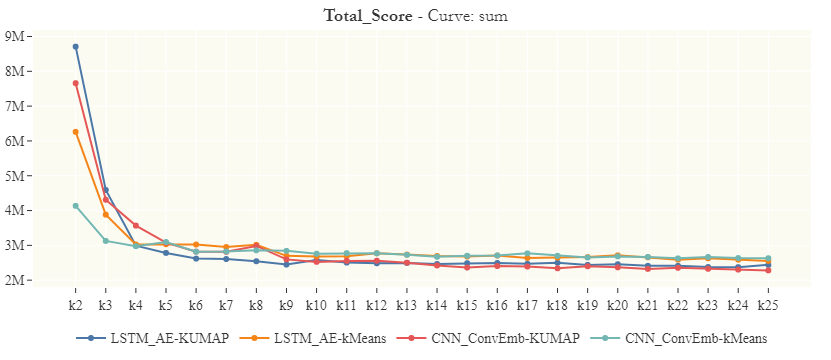

In [233]:
plot_all_elbow(sols = [S1_centers, S2_centers], sol_names = [S1_name, S2_name], var = 'Total_Score', line_type = 'sum')

### S1

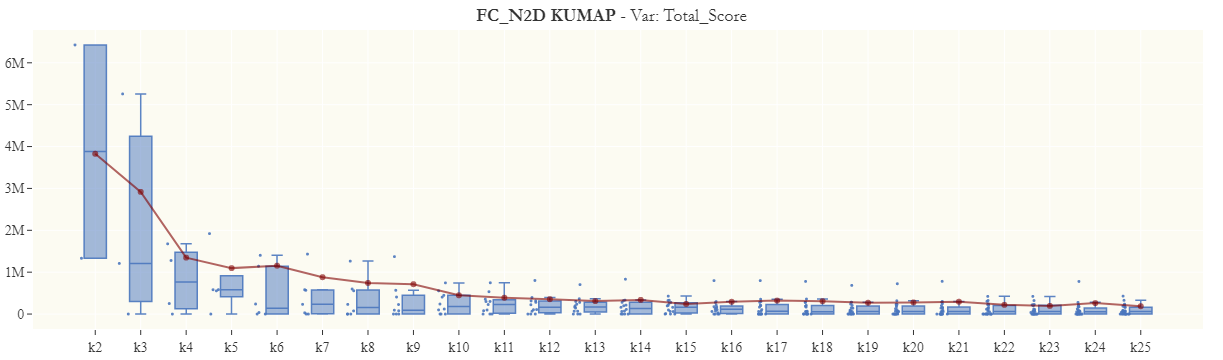

In [149]:
plot_elbow(S1_centers, sol_name=S1_name, alg='KUMAP', mode = 'Total_Score', line_type='w_avg')

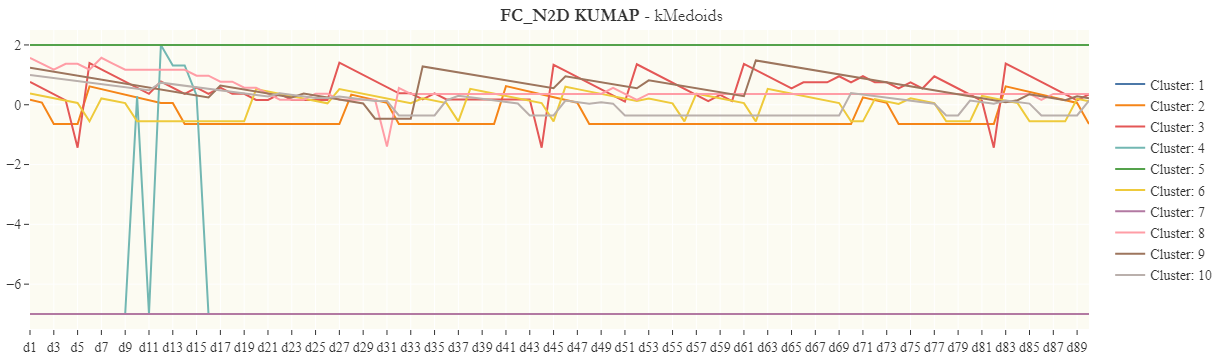

In [155]:
plot_centers(S1_centers, sol_location = S1_location, sol_name=S1_name, alg='KUMAP', k = 'k10')

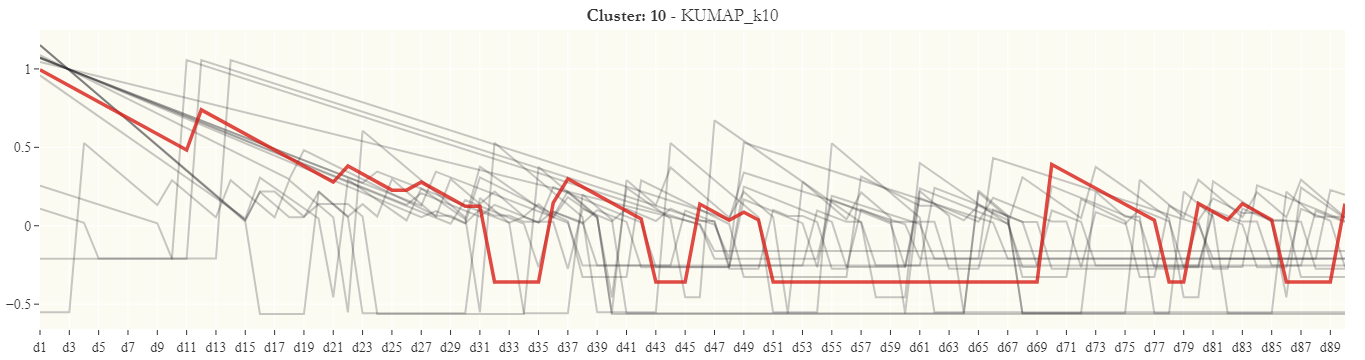

In [96]:
plot_cluster_samples(S1_centers, df_data, sol_location = S1_location, alg = 'KUMAP', k = 'k10', cluster=10, sample=15, seed=42)

### S2

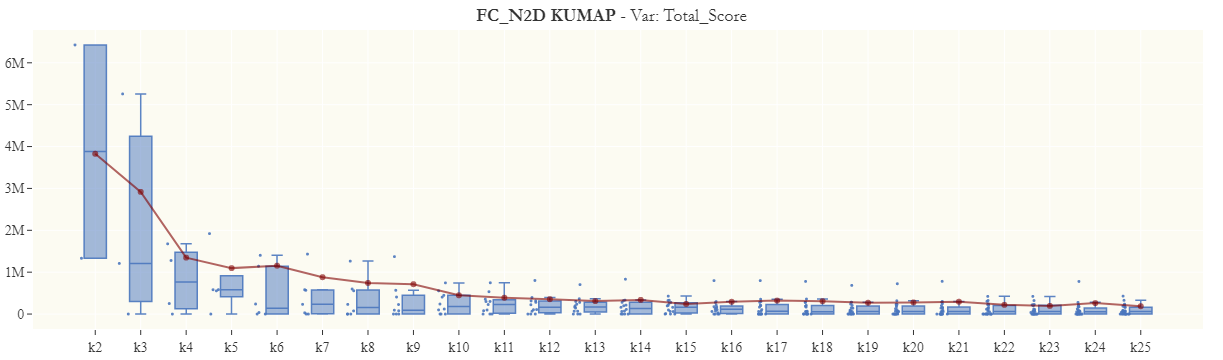

In [148]:
plot_elbow(S2_centers, sol_name=S2_name, alg='KUMAP', mode = 'Total_Score', line_type='w_avg')

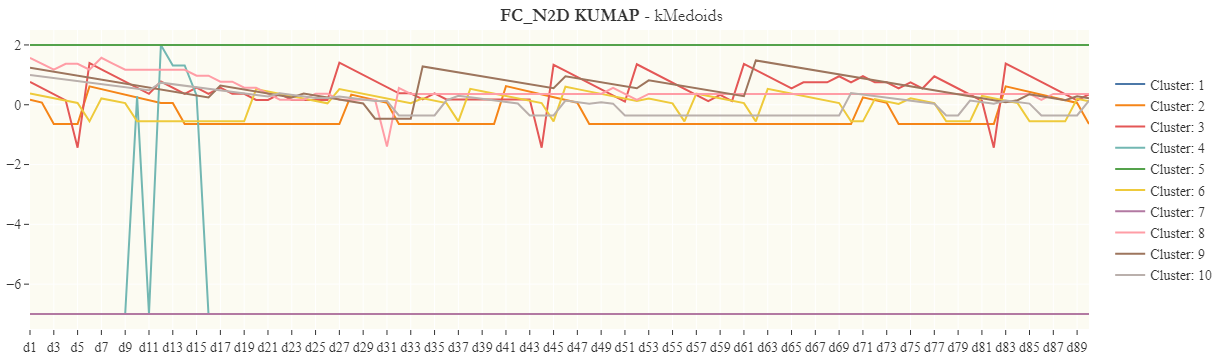

In [154]:
plot_centers(S2_centers, sol_location = S2_location, sol_name=S2_name, alg='KUMAP', k = 'k10')

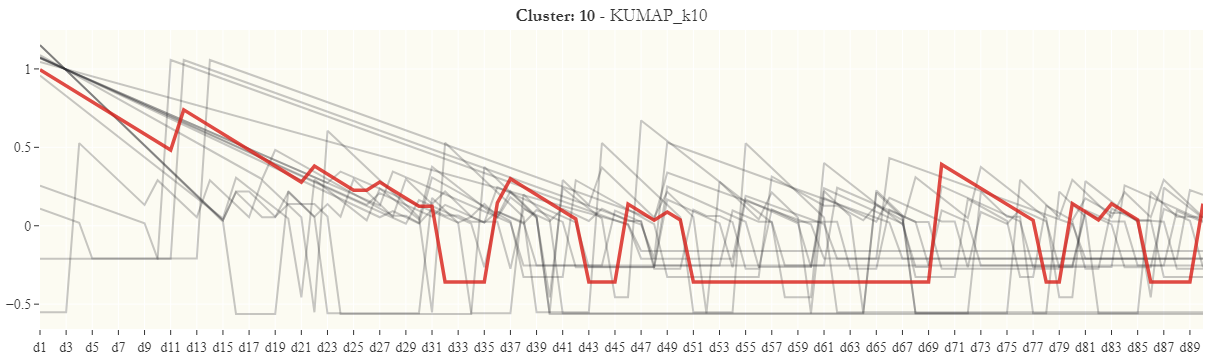

In [151]:
plot_cluster_samples(S2_centers, df_data, sol_location = S2_location, alg = 'KUMAP', k = 'k10', cluster=10, sample=15, seed=42)

---
# Cluster Pairs

In [6]:
def cluster_pairs (df_data, S1, alg1, k1, S2, alg2, k2):
    
    if k1 >= k2:
        k_base = int(k1[1:])
        k_comp = int(k2[1:])
        
        Sbase_location = S1_location
        alg_base = alg1 + '_' + k1
        
        Scomp_location = S2_location
        alg_comp = alg2 + '_' + k2
    else:
        k_base = int(k2[1:])
        k_comp = int(k1[1:])
        
        Sbase_location = S2_location
        alg_base = alg2 + '_' + k2
        
        Scomp_location = S1_location
        alg_comp = alg1 + '_' + k1
        
    cluster_pairs = {}    
    for c_base in range(1, k_base +1): 
        df_Sbase_ids = pl.scan_csv(Sbase_location).filter(pl.col(f"{alg_base}") == c_base).select(["short_ID", "window_ID"]).collect()
        df_Sbase_ids = df_Sbase_ids.join(df_data, on = ['short_ID', 'window_ID'], how='left')
        base_set = set(df_Sbase_ids.select("index").to_numpy().ravel().tolist())
        
        comp_IoU = []
        for c_comp in range(1, k_comp +1):       
            df_Scomp_ids = pl.scan_csv(Scomp_location).filter(pl.col(f"{alg_comp}") == c_comp).select(["short_ID", "window_ID"]).collect()
            df_Scomp_ids = df_Scomp_ids.join(df_data, on = ['short_ID', 'window_ID'], how='left')
            comp_set = set(df_Scomp_ids.select("index").to_numpy().ravel().tolist())
            
            Intersection = len(base_set.intersection(comp_set))
            Union = len(base_set.union(comp_set))
            comp_IoU.append(Intersection/Union)
            
        comp_IoU = np.array(comp_IoU)    
        cluster_pairs[c_base] = np.argmax(comp_IoU) + 1 #np.max(comp_IoU)# np.argmax(comp_IoU) + 1#np.min(comp_IoU) #np.argmin(comp_IoU) + 1
        
    print(f'Order: {alg_base} -> {alg_comp}')

    return cluster_pairs      


In [7]:
pairs = cluster_pairs (df_data_ids, S1 = S1_name, alg1 = 'KUMAP', k1 = 'k6', S2 = S2_name, alg2 = 'kMeans', k2 = 'k6')

Order: KUMAP_k6 -> kMeans_k6


In [8]:
list(pairs.keys())[0]

1

In [9]:
pairs[1]

3

In [10]:
def plot_cluster_pairs(pairs):
    

IndentationError: expected an indented block (4227719368.py, line 2)

---
Sol compare